In [ ]:
G_all_2 =[]
G_all_4 =[]
G_all_7 =[]
G_all_10=[]

for i in range(0,900,10):
    for j in range(0,900,10):
        style_image=tf.constant(tf.reshape(images_style[i:i+100,j:j+100],[1,100,100,1]))
        
        CS_2 =gram_matrix(conv_out2_S[0,:,:,:])
        CS_4 =gram_matrix(conv_out4_S[0,:,:,:])
        CS_7 =gram_matrix(conv_out7_S[0,:,:,:])
        CS_10=gram_matrix(conv_out10_S[0,:,:,:])
        
        G_all_2.append(CS_2)
        G_all_4.append(CS_4)
        G_all_7.append(CS_7)
        G_all_10.append(CS_10)
        
        

In [1]:
import scipy.io as sio
import time
import h5py
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

import tensorflow as tf
import random
height=100
width =100


Using TensorFlow backend.


In [2]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))
#     D=tf.sqrt(tf.diag(tf.diag_part(gram)))
#     Q=tf.matmul(tf.matmul(tf.matrix_inverse(D),gram),tf.matrix_inverse(D))
#     return (gram-tf.reduce_min(tf.reshape(gram,[-1])))/(tf.reduce_max(tf.reshape(gram,[-1]))-tf.reduce_min(tf.reshape(gram,[-1]))) 
#     gram_dig = tf.diag_part(gram)   
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
#     S = gram_matrix(style/1)
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2)))*1e-7
    
    return loss_temp

# def total_variation_loss(x):
#     a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
#     b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
#     return backend.sum(backend.pow(a + b, 1.25))

In [3]:
# ######## loading input data ########
# images = np.array(sio.loadmat('WB_sm.mat')['WB_sm'],dtype='float32')
# images = images[0:100]
# # images_style = images[1]

# # images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

# style_array = np.zeros([1,height,width,3])
# style_array[:,:,:,0]=(images_style.reshape(height,width))*255
# style_array[:,:,:,1]=(images_style.reshape(height,width))*255
# style_array[:,:,:,2]=(images_style.reshape(height,width))*255
# print(style_array.shape)
# plt.figure(figsize=(4, 4))
# plt.imshow(images_style.reshape(height*10,width*10),'gray')
# # plt.imshow(style_array.reshape(height,width,3),'gray')

In [4]:
######## loading input data ########
images = np.array(sio.loadmat('alloy_mat/circle_sm.mat')['xtr_store'],dtype='float32').T
# images_S=images
images = images[0:200]
# images_style = images[1]

# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

style_array = np.zeros([200,height,width,3])
style_array[:,:,:,0]=(images.reshape(200,height,width))*255
style_array[:,:,:,1]=(images.reshape(200,height,width))*255
style_array[:,:,:,2]=(images.reshape(200,height,width))*255
print(style_array.shape)

(200, 100, 100, 3)


In [5]:
######## weights & bias loaading ########
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [7]:
W_conv1.shape

TensorShape([Dimension(3), Dimension(3), Dimension(3), Dimension(64)])

In [6]:
######## VAE preperation ########
mb_size = 40
z_dim = 100/4
X_dim = images.shape[1]
h_dim = width/4*height/4

conv1_features=64*2
conv2_features=32*2
conv3_features=1

num_channels_1=1
num_channels_2=64*2
num_channels_3=32*2
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, height, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) ======================================
def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, height/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, height/2, conv1_features]),deconv1_bias))
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, height/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, height/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.sigmoid(h4)
    return prob


P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)

In [7]:
######## style transfer ########
combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*255
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [8]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [9]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [10]:
######## loss function ########
# sl1 = style_loss(conv_out2_S[0,:,:,:],conv_out2)
# sl2 = style_loss(conv_out4_S[0,:,:,:],conv_out4)
# sl3 = style_loss(conv_out7_S[0,:,:,:],conv_out7)
# sl4 = style_loss(conv_out10_S[0,:,:,:],conv_out10)
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out7_S,conv_out7)
sl4 = style_loss(conv_out10_S,conv_out10)


# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss =tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))



# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)
tot_loss = tf.reduce_mean(recon_loss + kl_loss + sl1 + sl2 + sl3 + sl4)
# tot_loss = tf.reduce_mean(recon_loss + kl_loss + sl3 + sl4)

In [11]:
######## Training ########
solver_VAE0 = tf.train.AdamOptimizer(learning_rate=lr).minimize(vae_loss)
solver_VAE1 = tf.train.AdamOptimizer(learning_rate=lr/10).minimize(vae_loss)

solver_ST0 = tf.train.AdamOptimizer(learning_rate=lr).minimize(tot_loss)
solver_ST1 = tf.train.AdamOptimizer(learning_rate=lr/10).minimize(tot_loss)
solver_ST2 = tf.train.AdamOptimizer(learning_rate=lr/100).minimize(tot_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()

for it in range(6000000):
    X_mb = images[random.sample(range(len(images)),  mb_size)]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     _, loss, recon_E, kl_E = sess.run([solver_VAE1, vae_loss, recon_loss, kl_loss],
#                                       feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                                  z: np.random.randn(mb_size, z_dim)})
#    
#    
    _, loss, recon_E, kl_E = sess.run([solver_VAE0, vae_loss, recon_loss, kl_loss],
                                      feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                 z: np.random.randn(mb_size, z_dim)})

    
    if it % 250 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#        print('style_E1:{}'.format(style_E1))
#        print('style_E2:{}'.format(style_E2))
#        print('style_E3:{}'.format(style_E3))
#        print('style_E4:{}'.format(style_E4))
        print()
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 689.460693359
recon_E:660.218322754
kl_E:29.2423934937
()
Iter: 250
Loss: 533.903198242
recon_E:523.003540039
kl_E:10.8996496201
()
Iter: 500
Loss: 522.946105957
recon_E:521.609680176
kl_E:1.33642411232
()
Iter: 750
Loss: 518.092285156
recon_E:515.859069824
kl_E:2.23320007324
()
Iter: 1000
Loss: 516.893005371
recon_E:497.535064697
kl_E:19.3579406738
()
Iter: 1250
Loss: 460.818725586
recon_E:427.555603027
kl_E:33.2631111145
()
Iter: 1500
Loss: 422.424835205
recon_E:378.407531738
kl_E:44.0172920227
()
Iter: 1750
Loss: 393.122833252
recon_E:343.985198975
kl_E:49.1376342773
()
Iter: 2000
Loss: 382.227294922
recon_E:329.63494873
kl_E:52.5923309326
()
Iter: 2250
Loss: 374.648986816
recon_E:316.218536377
kl_E:58.4304351807
()
Iter: 2500
Loss: 368.022644043
recon_E:309.244598389
kl_E:58.7780303955
()
Iter: 2750
Loss: 346.489135742
recon_E:285.488769531
kl_E:61.000377655
()
Iter: 3000
Loss: 336.561401367
recon_E:274.242004395
kl_E:62.3193893433
()
Iter: 3250
Loss: 315.143981934
re

KeyboardInterrupt: 

In [15]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")
for it in range(600000):
    X_mb = images[random.sample(range(len(images)),  mb_size)]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
    _, loss, recon_E, kl_E = sess.run([solver_VAE0, vae_loss, recon_loss, kl_loss], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim)})
    
#    
#     _, loss_tot, recon_E, kl_E, style_E1,style_E2,style_E3,style_E4= sess.run([solver_ST0, tot_loss, recon_loss, kl_loss, sl1, sl2, sl3, sl4], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim),
#                                                               style_image: style_array_input.reshape(mb_size,100,100,3)})

    
    if it % 250 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('style_E1:{}'.format(style_E1))
#         print('style_E2:{}'.format(style_E2))
#         print('style_E3:{}'.format(style_E3))
#         print('style_E4:{}'.format(style_E4))
        print()
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 247.628570557
recon_E:175.12612915
kl_E:72.5024414062
()
Iter: 250
Loss: 244.217727661
recon_E:171.206253052
kl_E:73.0114746094
()
Iter: 500
Loss: 256.120605469
recon_E:182.012023926
kl_E:74.1085662842
()
Iter: 750
Loss: 257.319335938
recon_E:183.170974731
kl_E:74.1483612061
()
Iter: 1000
Loss: 246.248016357
recon_E:174.640106201
kl_E:71.6079177856
()
Iter: 1250
Loss: 240.422943115
recon_E:166.288619995
kl_E:74.1343231201
()
Iter: 1500
Loss: 236.706115723
recon_E:162.158874512
kl_E:74.5472412109
()
Iter: 1750
Loss: 239.190948486
recon_E:164.955429077
kl_E:74.2355270386
()
Iter: 2000
Loss: 242.331253052
recon_E:168.72644043
kl_E:73.6048126221
()
Iter: 2250
Loss: 249.787902832
recon_E:175.695617676
kl_E:74.0922927856
()
Iter: 2500
Loss: 241.17175293
recon_E:167.152999878
kl_E:74.0187454224
()
Iter: 2750
Loss: 240.678985596
recon_E:167.871994019
kl_E:72.8069992065
()
Iter: 3000
Loss: 243.232559204
recon_E:169.789245605
kl_E:73.4433135986
()
Iter: 3250
Loss: 238.166061401
rec

KeyboardInterrupt: 

In [68]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")
# tot_loss = tf.reduce_mean(recon_loss + kl_loss + sl1*5e-3 + sl2*5e-3 + sl3 + sl4)
# solver_ST2 = tf.train.AdamOptimizer(learning_rate=lr/100).minimize(tot_loss)
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
for it in range(600000):
    X_mb = images[random.sample(range(len(images)),  mb_size)]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     _, loss, recon_E, kl_E = sess.run([solver_VAE0, vae_loss, recon_loss, kl_loss], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim)})
    
#    
    _, loss_tot, recon_E, kl_E, style_E1, style_E2, style_E3,style_E4= sess.run([solver_ST2, tot_loss, recon_loss, kl_loss, sl1, sl2, sl3, sl4], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array_input.reshape(mb_size,100,100,3)})

    
    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E1:{}'.format(style_E1))
        print('style_E2:{}'.format(style_E2))
        print('style_E3:{}'.format(style_E3*1e0))
        print('style_E4:{}'.format(style_E4*1e0))
        print()
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 566.841125488
recon_E:202.361450195
kl_E:102.370880127
style_E1:28.0349254608
style_E2:197.201080322
style_E3:36.8702430725
style_E4:0.00257299188524
()
Iter: 200
Loss: 601.137695312
recon_E:201.429214478
kl_E:100.922744751
style_E1:70.0853729248
style_E2:179.547851562
style_E3:49.1502838135
style_E4:0.00224054884166
()
Iter: 400
Loss: 447.127624512
recon_E:205.571334839
kl_E:101.747268677
style_E1:30.1216907501
style_E2:89.7989349365
style_E3:19.8865451813
style_E4:0.00182935339399
()
Iter: 600
Loss: 423.264251709
recon_E:195.675949097
kl_E:102.018737793
style_E1:9.58758831024
style_E2:90.9544372559
style_E3:25.0252761841
style_E4:0.00224715517834
()
Iter: 800
Loss: 594.302429199
recon_E:198.810272217
kl_E:103.366531372
style_E1:58.6645622253
style_E2:189.281524658
style_E3:44.1762046814
style_E4:0.00328548089601
()
Iter: 1000
Loss: 427.535949707
recon_E:203.388519287
kl_E:102.137756348
style_E1:13.7634544373
style_E2:85.6435775757
style_E3:22.6007900238
style_E4:0.00183

KeyboardInterrupt: 

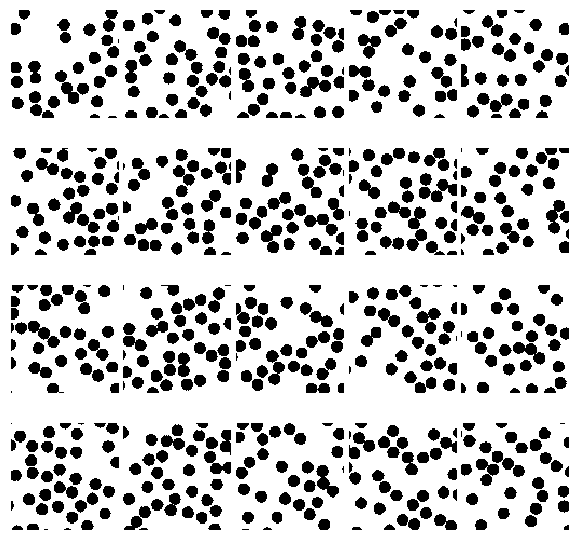

In [38]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(100, 100), cmap='Greys_r')

A=images[0:mb_size/2]
plot(A)

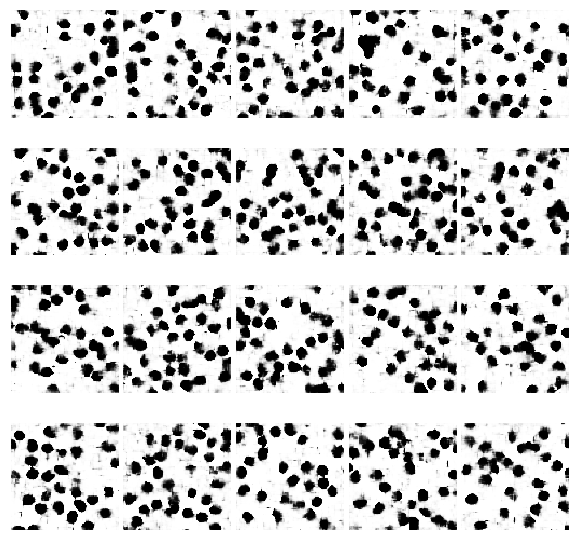

In [69]:
X_mb=images[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array_input.reshape(mb_size,100,100,3)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                           z: z_temp[0:mb_size],
                                           style_image: style_array_input.reshape(mb_size,100,100,3)})
# plot_new(sample_temp)
plot(sample_temp[0:20])

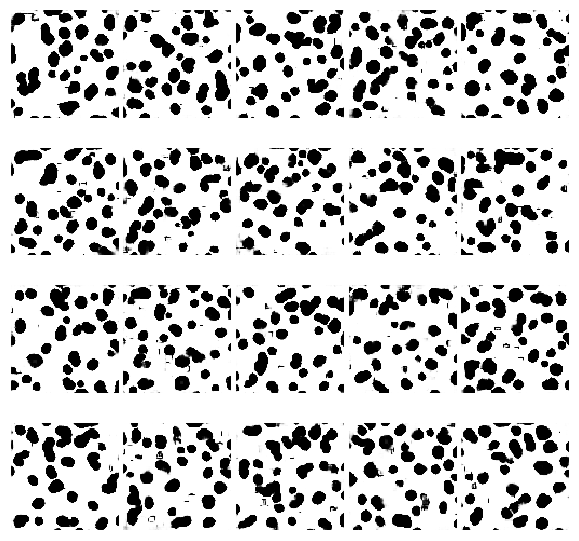

In [70]:
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
# sio.savemat('content_test.mat',mdict={'samples':samples})
plot(samples[0:20])

In [18]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(600000):
    X_mb = images[random.sample(range(len(images)),  mb_size)]
    
#     _, loss, recon_E, kl_E = sess.run([solver_VAE0, vae_loss, recon_loss, kl_loss], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim)})
    
#    
    _, loss_tot, recon_E, kl_E, style_E= sess.run([solver_ST0, tot_loss, recon_loss, kl_loss, sl1], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array.reshape(1,100,100,3)})

    
    if it % 250 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E:{}'.format(style_E))
        print()
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 2.7863524311e+12
recon_E:284.969360352
kl_E:56.5663146973
style_E:2.7863524311e+12
()
Iter: 250
Loss: 21838147584.0
recon_E:638.288696289
kl_E:44.8274612427
style_E:21838147584.0
()
Iter: 500
Loss: 14904066048.0
recon_E:664.659179688
kl_E:42.2936248779
style_E:14904065024.0
()
Iter: 750
Loss: 12465932288.0
recon_E:673.432800293
kl_E:45.0300674438
style_E:12465931264.0
()
Iter: 1000
Loss: 9711485952.0
recon_E:691.340209961
kl_E:43.8217697144
style_E:9711484928.0
()
Iter: 1250
Loss: 9448715264.0
recon_E:702.539428711
kl_E:40.8071365356
style_E:9448714240.0
()
Iter: 1500
Loss: 7913483776.0
recon_E:707.729064941
kl_E:41.4741706848
style_E:7913483264.0
()
Iter: 1750
Loss: 7248687104.0
recon_E:697.572265625
kl_E:44.5731582642
style_E:7248686592.0
()
Iter: 2000
Loss: 7554547200.0
recon_E:714.764221191
kl_E:42.2383956909
style_E:7554546688.0
()
Iter: 2250
Loss: 6457944064.0
recon_E:703.466552734
kl_E:44.4317741394
style_E:6457943552.0
()


KeyboardInterrupt: 

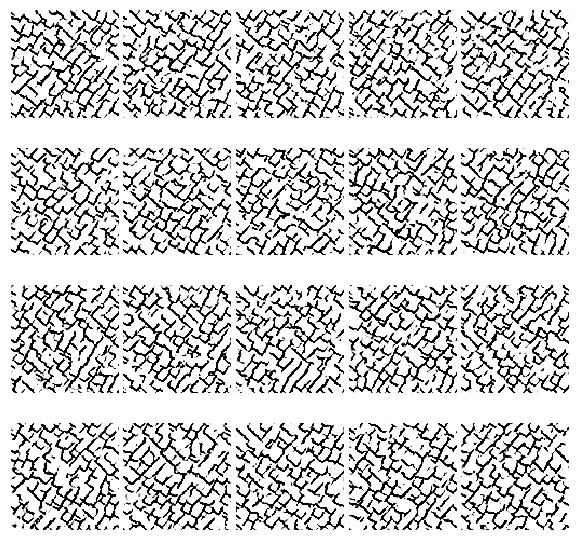

In [19]:
samples = sess.run(X_samples, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array.reshape(1,100,100,3)})
# sio.savemat('content_test.mat',mdict={'samples':samples})
plot(samples)

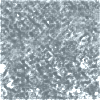

In [17]:
test=sess.run(combination_image,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array.reshape(1,1000,1000,3)})
test = test[3].reshape((100, 100, 3))
test = test[:, :, ::-1]
test[:, :, 0] += 103.939
test[:, :, 1] += 116.779
test[:, :, 2] += 123.68
test = np.clip(test, 0, 255).astype('uint8')
Image.fromarray(test)

In [34]:
test=sess.run(conv_out2_S[0,:,:,:], feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array.reshape(1,1000,1000,3)})

test1=sess.run(conv_out2[0,:,:,:], feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: style_array.reshape(1,1000,1000,3)})

(500, 500, 64)


(array([  1.26338000e+05,   1.29860000e+04,   6.71400000e+03,
          7.98700000e+03,   2.61400000e+03,   2.59600000e+03,
          2.84000000e+02,   2.38000000e+02,   5.10000000e+01,
          1.92000000e+02]),
 array([    0.        ,   311.04216309,   622.08432617,   933.12648926,
         1244.16865234,  1555.21081543,  1866.25297852,  2177.2951416 ,
         2488.33730469,  2799.37946777,  3110.42163086]),
 <a list of 10 Patch objects>)

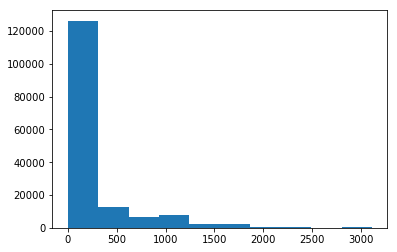

In [40]:
print(test.shape)
plt.hist(test1.reshape(-1))

In [13]:
# conv_out1
conv_out1_test = sess.run(conv_out1,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images[25].reshape(1,32,32,1)})
# conv_out1_S_test = sess.run(conv_out1_S,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim),
#                                                               style_image: images[0].reshape(1,32,32,1)})

ValueError: Cannot feed value of shape (1, 32, 32, 1) for Tensor u'Placeholder_11:0', which has shape '(1, 100, 100, 1)'

In [59]:
conv_out1_S_test = sess.run(conv_out1_S,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images[25].reshape(1,32,32,1)})


(array([ 45786.,  20137.,  20783.,  17640.,  18337.,  18418.,  17842.,
         21146.,  19494.,  40417.]),
 array([  3.18340739e-07,   1.00000251e-01,   2.00000183e-01,
          3.00000116e-01,   4.00000048e-01,   4.99999980e-01,
          5.99999913e-01,   6.99999845e-01,   7.99999778e-01,
          8.99999710e-01,   9.99999642e-01]),
 <a list of 10 Patch objects>)

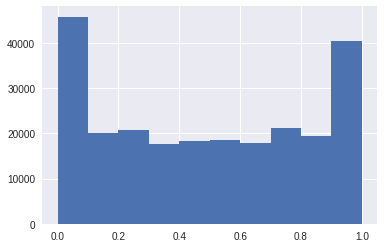

In [27]:
plt.hist(conv_out1_S_test.reshape(-1))

(array([ 3338.,  2187.,  2196.,  2212.,  2377.,  2382.,  2233.,  2336.,
         2266.,  3049.]),
 array([  5.60305525e-05,   1.00044145e-01,   2.00032260e-01,
          3.00020374e-01,   4.00008489e-01,   4.99996604e-01,
          5.99984718e-01,   6.99972833e-01,   7.99960947e-01,
          8.99949062e-01,   9.99937177e-01]),
 <a list of 10 Patch objects>)

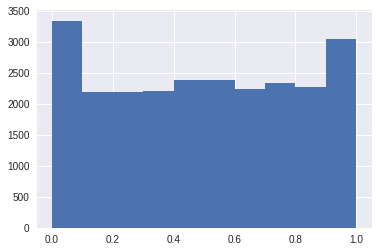

In [28]:
plt.hist(conv_out1_test.reshape(-1))

In [15]:
def get_shape(inp):
    # returns the shape of a tensor or an array
    if type(inp) == type(np.array([])):
        return inp.shape
    else:
        return [i.value for i in inp.get_shape()]

(array([  174.,  1682.,  3818.,  2720.,   652.,    70.,     7.,    43.,
           36.,    14.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

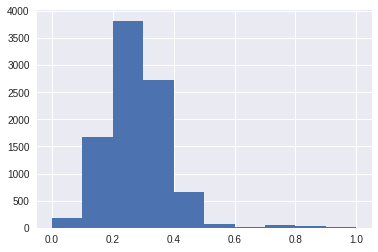

In [30]:
temp=conv_out1_test.reshape(-1, get_shape(conv_out1_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
# temp_tot=(temp_tot-np.mean(temp_tot))/np.std(temp_tot)
temp_tot=(temp_tot-np.min(temp_tot.reshape(-1)))/(np.max(temp_tot.reshape(-1))-np.min(temp_tot.reshape(-1)))

plt.hist(temp_tot.reshape(-1))

(array([  1.58000000e+02,   1.74000000e+03,   3.80800000e+03,
          2.67600000e+03,   6.56000000e+02,   8.00000000e+01,
          3.00000000e+00,   4.20000000e+01,   3.90000000e+01,
          1.40000000e+01]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

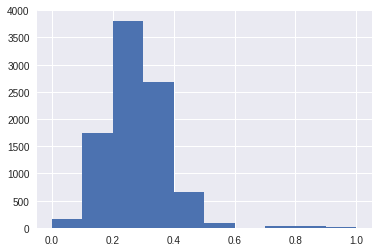

In [31]:
conv_out1_S_test = sess.run(conv_out1_S,feed_dict={style_image: images_style.reshape(1,100,100,1)})
temp=conv_out1_S_test.reshape(-1, get_shape(conv_out1_S_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot_S=np.dot(temp.T,temp)
# temp_tot=(temp_tot-np.mean(temp_tot))/np.std(temp_tot)
temp_tot_S=(temp_tot_S-np.min(temp_tot_S.reshape(-1)))/(np.max(temp_tot_S.reshape(-1))-np.min(temp_tot_S.reshape(-1)))

plt.hist(temp_tot_S.reshape(-1))

(array([  90.,  145.,  149.,  123.,   41.,   22.,    2.,    3.,    0.,    1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

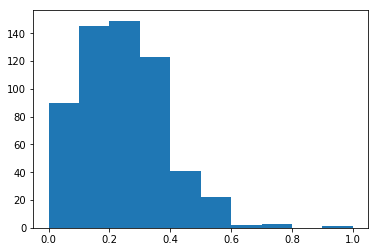

In [25]:
# conv_out1
conv_out1_test = sess.run(conv_out1,feed_dict={combination_image: samples[0].reshape(1,32,32,1)})
temp=conv_out1_test.reshape(-1, get_shape(conv_out1_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
temp_tot=(temp_tot-np.min(temp_tot.reshape(-1)))/(np.max(temp_tot.reshape(-1))-np.min(temp_tot.reshape(-1)))

plt.hist(temp_tot.reshape(-1))

In [31]:
A=np.array([[1,2,3],[4,5,6]])


array([[14, 32],
       [32, 77]])

In [24]:
temp_tot

array([[ 28.60391808,  25.85473251,  18.41759491,  17.38870049,
         13.81106472,  16.16987419,  12.02762985,  12.13709736,
          8.80450058,   9.10315132,   8.35223198,  11.91192436,
         19.05091095,  22.4243679 ,  19.51883316,  20.48875237,
         16.39320183,  16.78019142,  10.73654461,   9.09595394,
          5.25428724,   5.31959486,   5.63035631,   8.20598602],
       [ 25.85473251,  27.80596542,  22.66958237,  22.31842422,
         18.33329964,  21.25834465,  16.26270103,  16.17731667,
         11.09975624,   9.78308201,   7.72543287,   9.98926926,
         16.84298897,  21.10267448,  19.84857559,  22.43780327,
         19.44999695,  21.55651665,  15.52490902,  14.19087315,
          8.38851643,   6.86140966,   5.97387695,   7.46108866],
       [ 18.41759491,  22.66958237,  21.21835136,  22.19033241,
         18.79650688,  21.67465019,  16.82329559,  16.59044838,
         11.27865887,   9.29733849,   6.59909725,   7.4123621 ,
         11.88932991,  16.06929588,  1

In [37]:
np.mean(np.square(temp_tot-temp_tot_S))

0.00043939624

In [151]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(400000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     _, loss, recon_E, kl_E = sess.run([solver, vae_loss, recon_loss, kl_loss], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim)})
    _, loss_tot, recon_E, kl_E, style_E= sess.run([solver2, tot_loss, recon_loss, kl_loss, sl1], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images_style.reshape(1,100,100,1)})

    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E:{}'.format(style_E))
#         print('Var_E:{}'.format(Var_E))
        print()

#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 109.218139648
recon_E:60.6504898071
kl_E:33.6590118408
style_E:5.08268547058
()
Iter: 1000
Loss: 81.1686019897
recon_E:39.0911941528
kl_E:33.5824127197
style_E:1.45243608952
()
Iter: 2000
Loss: 87.9397506714
recon_E:42.7844619751
kl_E:33.3720550537
style_E:2.51881146431
()
Iter: 3000
Loss: 88.1022109985
recon_E:43.8763465881
kl_E:33.7444267273
style_E:2.39647912979
()
Iter: 4000
Loss: 82.0798797607
recon_E:38.22996521
kl_E:33.5617446899
style_E:2.13005638123
()
Iter: 5000
Loss: 88.5453338623
recon_E:42.7216567993
kl_E:33.8388137817
style_E:2.5379087925
()
Iter: 6000
Loss: 89.8638153076
recon_E:47.3154144287
kl_E:33.1777229309
style_E:1.64709532261
()
Iter: 7000
Loss: 91.6103973389
recon_E:46.5632400513
kl_E:33.4258956909
style_E:2.72247695923
()
Iter: 8000
Loss: 96.4542922974
recon_E:53.8019790649
kl_E:33.20728302
style_E:3.04542660713
()
Iter: 9000
Loss: 90.2174987793
recon_E:45.7562294006
kl_E:33.1273765564
style_E:2.58134150505
()
Iter: 10000
Loss: 108.29384613
recon_E

KeyboardInterrupt: 

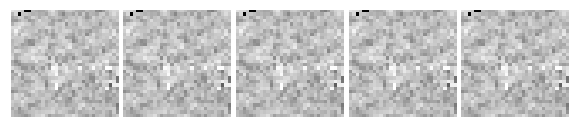

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

X_mb=images[30:35]
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(sample_temp)

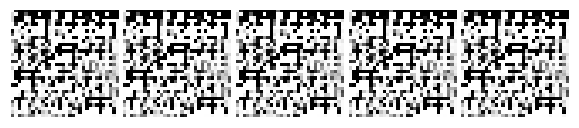

In [10]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

#     return fig
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
sample_sort=samples.reshape(-1)
# sample_sort.sort()
# samples[samples>=(np.sort(sample_sort))[300]]=1
# samples[samples<(np.sort(sample_sort))[300]]=-1
plot(samples)

In [75]:
def correlation_fun_test(xx,input_dim,Rad):
    sum_store=[]
    for ii in range(len(xx)):
        x = xx[ii]
        point_corr=0
#     if Rad <=50:
        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp1=(x[i,j]*x[i,np.mod(j+Rad,input_dim)])
                point_corr=point_corr_temp1+point_corr

        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp2=x[i,j]*x[np.mod(i+Rad,input_dim),j]
                point_corr=(point_corr_temp2+point_corr)
        sum_store.append((point_corr+2*input_dim**2)/4.)
#     print(point_corr)
    return sum_store

In [76]:
S2 = np.zeros([2*mb_size,17])
for i in range(2):
    samples=sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
    for j in range(17):
        S2[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=samples,input_dim=32,Rad=j)
#     plt.hist(samples.reshape(-1))

S2_ori = np.zeros([2*mb_size,17])
for i in range(2):
    for j in range(17):
        sample_ori=images[i*mb_size:(i+1)*mb_size].reshape(mb_size,32,32,1)
        S2_ori[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=sample_ori,input_dim=32,Rad=j)

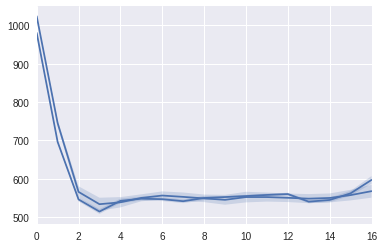

In [77]:
import seaborn as sns
%matplotlib inline
x = np.linspace(0, 16, 17)
sns.tsplot(data=S2)
sns.tsplot(data=S2_ori)

In [138]:
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
print z_temp.shape
test1=z_temp[1,:]
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})

(5, 8)


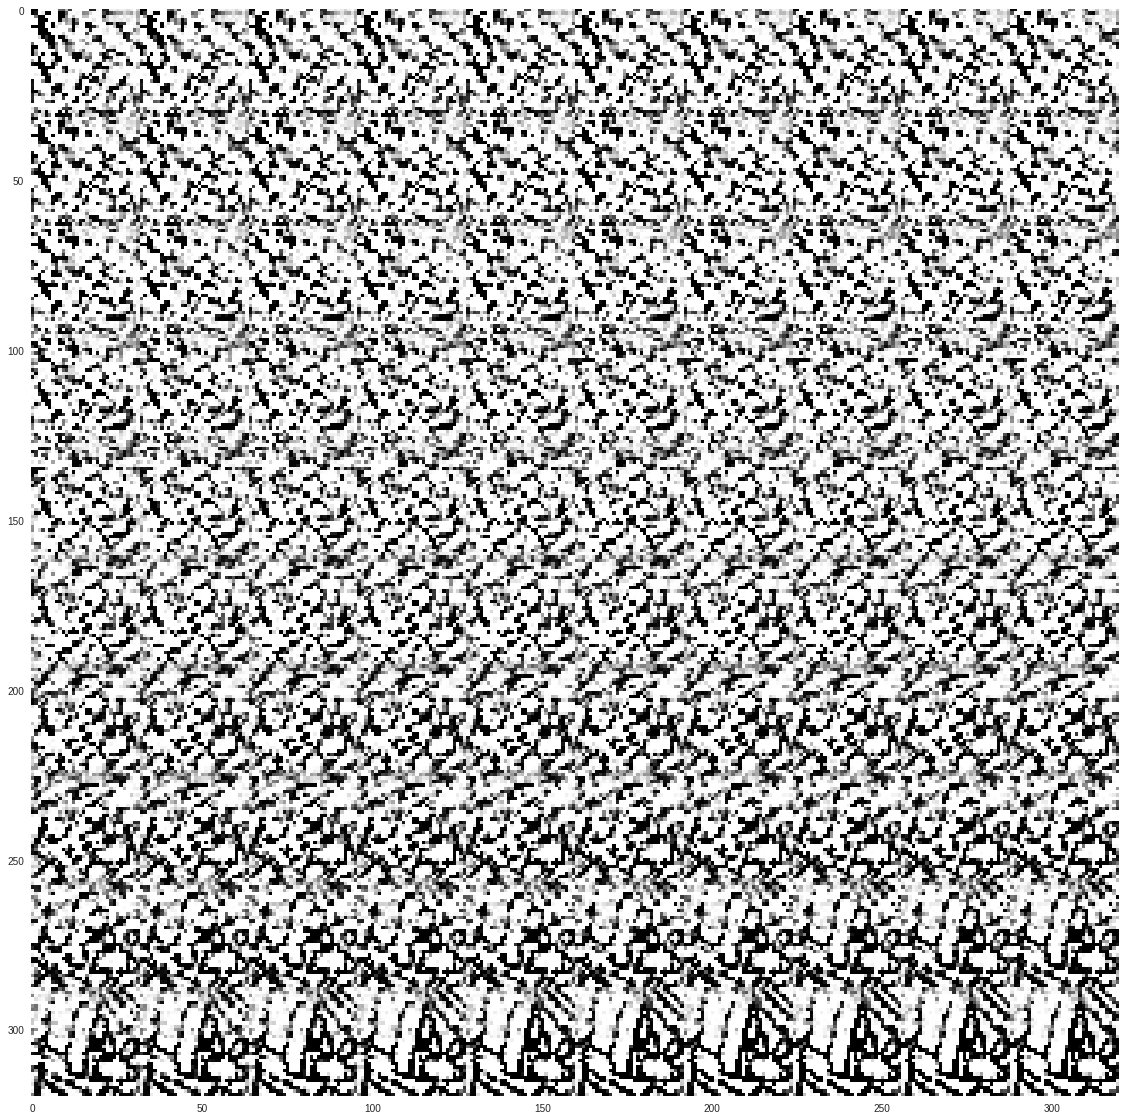

In [139]:
import matplotlib.pyplot as plt
n = 10  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        xi=np.linspace(-2, 2, 100)[k];k=k+1
        z_sample = np.array([[xi,test1[1],test1[2],test1[3],test1[4],test1[5],test1[6],test1[7]]]) 
#         z_sample = z_temp[3]
        z_temp[0] = z_sample
        x_decoded = (sess.run(X_samples, feed_dict={z: z_temp}))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.grid(False)
plt.imshow(figure,'gray')
plt.show()

ValueError: total size of new array must be unchanged

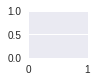

In [140]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 32  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(4, n/4, i + 1)
    plt.imshow(W3[:,:,:,i].reshape(4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Using TensorFlow backend.


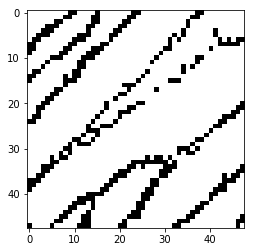

In [1]:
import scipy.io as sio
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
height=48
width =48
W1 = np.array(sio.loadmat('W1_Ti.mat')['W1'],dtype='float32')
W2 = np.array(sio.loadmat('W2_Ti.mat')['W2'],dtype='float32')
W3 = np.array(sio.loadmat('W3_Ti.mat')['W3'],dtype='float32')
images = np.array(sio.loadmat('WB_test64_GAN_sm.mat')['WB_sm'],dtype='float32')
style_img=images[3].reshape(1,height,width,1)
plt.imshow(style_img.reshape(height,width),'gray')

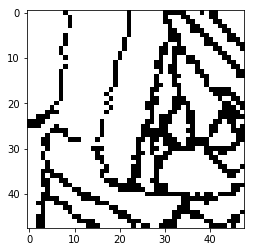

In [2]:
content_img=images[1].reshape(1,height,width,1)
plt.imshow(content_img.reshape(height,width),'gray')

In [3]:
style_image = backend.variable(style_img)
content_image = backend.variable(content_img)
combination_image = backend.placeholder((1, height, width, 1))

In [4]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="VALID"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 1
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))*10000

In [5]:
import tensorflow as tf
W_conv1 = tf.reshape(tf.constant(W1),[6,6,1,24])
W_conv2 = tf.reshape(tf.constant(W2),[9,9,24,40])
W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])

############# white noise ############
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

# conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
# conv_out2 = tf.nn.sigmoid(conv_out2)
# conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

# conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
# conv_out3 = tf.nn.sigmoid(conv_out3)

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

# conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
# conv_out2_S = tf.nn.sigmoid(conv_out2_S)
# conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

# conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
# conv_out3_S = tf.nn.sigmoid(conv_out3_S)

############# content image ############
conv_out1_C = conv2d(content_image, W_conv1, stride=1, padding='SAME')
conv_out1_C = tf.nn.sigmoid(conv_out1_C)
conv_out1_C = max_pool(conv_out1_C, k_size=2, stride=2, padding="SAME")

In [6]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_image_features = conv_out1_C
combination_features = conv_out1

cl = content_loss(content_image_features,combination_features)*10000

In [7]:
loss = backend.variable(0.)

sl1 = style_loss(conv_out1[0,:,:,:], conv_out1_S[0,:,:,:])
# sl2 = style_loss(conv_out2[0,:,:,:], conv_out2_S[0,:,:,:])
# sl3 = style_loss(conv_out3[0,:,:,:], conv_out3_S[0,:,:,:])

loss = sl1 + cl

grads = backend.gradients(loss, combination_image)

In [8]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 1))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [15]:
x = np.random.uniform(-1, 1, (1, height, width, 1))

iterations = 4000

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=40)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', 9903663.0)
Iteration 0 completed in 0s
('Start of iteration', 1)
('Current loss value:', 5087829.5)
Iteration 1 completed in 0s
('Start of iteration', 2)
('Current loss value:', 4426694.5)
Iteration 2 completed in 0s
('Start of iteration', 3)
('Current loss value:', 3854667.2)
Iteration 3 completed in 0s
('Start of iteration', 4)
('Current loss value:', 3366360.0)
Iteration 4 completed in 0s
('Start of iteration', 5)
('Current loss value:', 2951377.8)
Iteration 5 completed in 0s
('Start of iteration', 6)
('Current loss value:', 2598152.2)
Iteration 6 completed in 0s
('Start of iteration', 7)
('Current loss value:', 2296351.5)
Iteration 7 completed in 0s
('Start of iteration', 8)
('Current loss value:', 2037489.5)
Iteration 8 completed in 0s
('Start of iteration', 9)
('Current loss value:', 1814755.9)
Iteration 9 completed in 0s
('Start of iteration', 10)
('Current loss value:', 1622582.9)
Iteration 10 completed in 0s
('Start of iteratio

KeyboardInterrupt: 

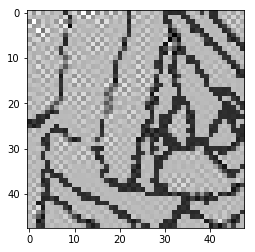

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
x = x.reshape((height, width, 1))
plt.imshow(x.reshape(48,48),'gray')